# Analisis dan Peramalan Kunjungan Wisata Kota Batu

Dokumen ini menyajikan metodologi langkah demi langkah untuk proyek **Kota Batu Tourism Insight & Forecast Engine**. Tujuannya adalah untuk menganalisis data kunjungan historis, mengidentifikasi pola-pola kunci, dan membangun model *machine learning* untuk memprediksi volume wisatawan di masa depan. Pendekatan ini menggunakan data dari tahun 2022 dan 2024, dengan perhatian khusus pada penanganan kekosongan data pada tahun 2023.


### **Pendahuluan dan Tujuan**

Notebook ini merupakan dokumentasi teknis untuk dasbor analitik pariwisata Kota Batu. Tujuannya adalah untuk melakukan analisis data secara komprehensif dan membangun tiga model peramalan yang berbeda untuk dibandingkan kinerjanya.

**Metodologi yang Diterapkan:**
1.  **Pemuatan & Pra-pemrosesan Data**: Memuat data mentah dari Excel, membersihkannya, dan melakukan interpolasi untuk mengisi data tahun 2023 yang kosong.
2.  **Analisis Data Eksploratif (EDA)**: Memvalidasi hipotesis terkait tren, musiman, dan dependensi temporal.
3.  **Perbandingan Kinerja Model**: Membangun dan mengevaluasi tiga model berbeda pada data uji (data yang belum pernah dilihat model):
    * **SARIMA**: Model statistik klasik untuk data time series musiman.
    * **Prophet**: Model dari Facebook yang andal untuk data dengan tren dan musiman yang kuat.
    * **XGBoost**: Model *machine learning* berbasis *tree* yang dapat menangkap hubungan non-linear.
4.  **Analisis Faktor Pendorong**: Menginterpretasikan model XGBoost untuk memahami faktor apa yang paling memengaruhi prediksi.
5.  **Peramalan Masa Depan**: Menggunakan ketiga model untuk memproyeksikan jumlah kunjungan di masa mendatang.

In [13]:
# Impor Library Awal (seluruh library yang dibutuhkan)
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Impor library untuk model dan evaluasi
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Pengaturan
warnings.filterwarnings('ignore')
px.defaults.template = "plotly_white"
print("Semua library berhasil diimpor.")

Semua library berhasil diimpor.


## **1. Persiapan Data (Data Preparation)**

Tahap fundamental ini bertujuan untuk membersihkan, menstrukturkan, dan menggabungkan data mentah menjadi sebuah dataset yang siap untuk dianalisis dan dimodelkan. Kualitas dari tahap ini sangat menentukan keberhasilan tahap-tahap berikutnya.

### **1.1. Pemuatan dan Penggabungan Data**

Data kunjungan wisatawan tahun 2022 dan 2024 dimuat dari masing-masing file CSV. Kedua dataset ini kemudian digabungkan menjadi satu DataFrame tunggal untuk memungkinkan analisis deret waktu yang berkelanjutan, meskipun terdapat jeda waktu.

In [14]:
def load_and_merge_data():
    """
    Fungsi final yang memuat, membersihkan, dan mentransformasi data dari file Excel.
    """
    def find_header_row(excel_file, sheet_name):
        try:
            df_scan = pd.read_excel(excel_file, sheet_name=sheet_name, header=None)
            max_score = 0
            header_row = -1
            keywords = ['NAMA', 'USAHA', 'JANUARI', 'FEBRUARI', 'MARET']
            for i, row in df_scan.head(30).iterrows():
                row_str = ' '.join(str(x).upper() for x in row.dropna())
                score = sum(1 for keyword in keywords if keyword in row_str)
                if score >= 2 and score > max_score:
                    max_score = score
                    header_row = i
            return header_row if header_row != -1 else 20
        except Exception:
            return 20

    def clean_sheet(df, year):
        if df.empty: return pd.DataFrame()
        df.columns = [str(col).strip() for col in df.columns]
        df.dropna(how='all', inplace=True)
        nama_usaha_col = next((col for col in df.columns if 'NAMA' in str(col).upper() and 'USAHA' in str(col).upper()), df.columns[1])
        df = df.rename(columns={nama_usaha_col: 'destinasi'})
        months = ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember']
        existing_months = [col for col in months if col in df.columns]
        if not existing_months: return pd.DataFrame()
        df_filtered = df[pd.to_numeric(df['destinasi'], errors='coerce').isna()]
        keywords_to_exclude = ['JUMLAH', 'KETERANGAN', 'Jumlah', 'TOTAL']
        mask = ~df_filtered['destinasi'].astype(str).str.contains('|'.join(keywords_to_exclude), na=False, case=False)
        df_filtered = df_filtered[mask]
        if df_filtered.empty: return pd.DataFrame()
        df_long = df_filtered.melt(id_vars='destinasi', value_vars=existing_months, var_name='bulan_str', value_name='jumlah_wisatawan')
        df_long['jumlah_wisatawan'] = pd.to_numeric(df_long['jumlah_wisatawan'], errors='coerce').fillna(0)
        month_map = {nama: i+1 for i, nama in enumerate(months)}
        df_long['bulan'] = df_long['bulan_str'].map(month_map)
        df_long['tahun'] = year
        df_long.dropna(subset=['tahun', 'bulan'], inplace=True)
        if df_long.empty: return pd.DataFrame()
        df_long['tanggal'] = pd.to_datetime(df_long['tahun'].astype(str) + '-' + df_long['bulan'].astype(str) + '-01', errors='coerce')
        df_long.dropna(subset=['tanggal'], inplace=True)
        return df_long

    excel_file_path = 'DDA2025_DinasPariwisata.xlsx'
    try:
        xls = pd.ExcelFile(excel_file_path)
        header_2022 = find_header_row(xls, 'Data 2022')
        header_2023 = find_header_row(xls, 'Data 2023')  
        header_2024 = find_header_row(xls, 'Data 2024')
        df_2022 = pd.read_excel(xls, sheet_name='Data 2022', skiprows=header_2022)
        df_2023 = pd.read_excel(xls, sheet_name='Data 2023', skiprows=header_2023) 
        df_2024 = pd.read_excel(xls, sheet_name='Data 2024', skiprows=header_2024)
    except FileNotFoundError:
        print(f"❌ ERROR: File '{excel_file_path}' tidak ditemukan!")
        return None
    except Exception as e:
        print(f"❌ ERROR saat membaca file Excel: {e}")
        return None

    # Bersihkan semua tahun
    df_2022_clean = clean_sheet(df_2022, 2022)
    df_2023_clean = clean_sheet(df_2023, 2023) 
    df_2024_clean = clean_sheet(df_2024, 2024)

    if all(df.empty for df in [df_2022_clean, df_2023_clean, df_2024_clean]):
        return None

    df_full = pd.concat([df_2022_clean, df_2023_clean, df_2024_clean], ignore_index=True)
    if df_full.empty: return None

    df_agregat = df_full.groupby('tanggal')['jumlah_wisatawan'].sum().reset_index().set_index('tanggal')
    return df_agregat


# Panggil fungsi
df_agregat = load_and_merge_data()
if df_agregat is not None:
    print("\n✅ Variabel `df_agregat` berhasil dibuat.")
else:
    print("\n❌ Gagal membuat `df_agregat`. Periksa error di atas.")



✅ Variabel `df_agregat` berhasil dibuat.


### **1.2. Pembersihan dan Transformasi**

Proses ini adalah inti dari persiapan data, yang melibatkan beberapa langkah krusial:
- **Transformasi Format (Wide-to-Long):** Dataset asli memiliki format *wide*, di mana setiap bulan adalah sebuah kolom. Format ini diubah menjadi format *long* (Tidy Data), di mana terdapat satu kolom untuk bulan dan satu kolom untuk jumlah wisatawan. Transformasi ini wajib dilakukan untuk hampir semua analisis deret waktu dan pemodelan di Python.
- **Pembuatan Kolom `datetime`:** Kolom tanggal (`tanggal`) dibuat dengan menggabungkan informasi tahun dan bulan. Kolom ini menjadi indeks dari DataFrame, yang merupakan syarat utama untuk analisis deret waktu yang benar.
- **Agregasi Data:** Untuk analisis makro awal, data dari semua destinasi dijumlahkan untuk mendapatkan total kunjungan wisatawan Kota Batu per bulan. Ini memberikan gambaran umum tentang tren pariwisata di seluruh kota.
- **Penanganan Nilai Hilang:** Nilai-nilai yang tidak valid atau kosong pada kolom `jumlah_wisatawan` diisi dengan angka 0, dengan asumsi bahwa data kosong berarti tidak ada laporan kunjungan pada periode tersebut.

---

In [15]:
if df_agregat is not None:
    # Membuat rentang tanggal penuh dari data agregat
    full_date_range = pd.date_range(start=df_agregat.index.min(), end=df_agregat.index.max(), freq='MS')
    df_final = df_agregat.reindex(full_date_range)
    
    # Melakukan interpolasi linear
    df_final['jumlah_wisatawan'] = df_final['jumlah_wisatawan'].interpolate(method='linear').fillna(0)

    print("✅ Data berhasil ditransformasi dan diinterpolasi.")
    print("\nInfo Data Final:")
    df_final.info()
    print("\n5 Baris Pertama Data Final:")
    print(df_final.head())

✅ Data berhasil ditransformasi dan diinterpolasi.

Info Data Final:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2022-01-01 to 2024-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   jumlah_wisatawan  36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes

5 Baris Pertama Data Final:
            jumlah_wisatawan
2022-01-01         1607143.0
2022-02-01         1231924.0
2022-03-01         1461713.0
2022-04-01          528238.0
2022-05-01         2906199.0


## **2. Analisis Data Eksploratif (Exploratory Data Analysis - EDA)**

EDA bertujuan untuk menggali wawasan awal, memahami karakteristik data, dan menguji hipotesis secara visual sebelum melangkah ke pemodelan yang lebih kompleks.

### **2.1. Analisis Tren Keseluruhan**

Grafik garis dari total kunjungan wisatawan dari waktu ke waktu diplot untuk mengidentifikasi tren jangka panjang, volatilitas, dan pola-pola utama. Visualisasi ini secara gamblang menunjukkan adanya **kekosongan data (gap) pada tahun 2023**, yang merupakan tantangan utama dalam proyek ini.

In [17]:
# ==============================================================================
# KODE VISUALISASI DENGAN INDENTASI YANG SUDAH DIPERBAIKI
# ==============================================================================

if df_final is not None and not df_final.empty:
    print("\n✅ Data siap untuk divisualisasikan. Memulai proses plotting...")
    print("--------------------------------------------------\n")
    
    # 3.1. Visualisasi Tren Kunjungan Bulanan
    print("Membuat plot: 3.1. Visualisasi Tren Kunjungan Bulanan...")
    fig_line = px.line(df_final, x=df_final.index, y='jumlah_wisatawan', markers=True,
                         title='Tren Total Kunjungan Wisatawan Bulanan (2022-2024)',
                         labels={'index': 'Tanggal', 'jumlah_wisatawan': 'Jumlah Pengunjung'})
    fig_line.show()

    # 3.2. Analisis Musiman (Validasi Hipotesis 1)
    print("Membuat plot: 3.2. Analisis Musiman...")
    df_monthly = df_final.copy()
    df_monthly['bulan_nama'] = df_monthly.index.month_name()
    fig_box = px.box(df_monthly, x='bulan_nama', y='jumlah_wisatawan',
                       title='Analisis Musiman: Distribusi Kunjungan per Bulan',
                       labels={'bulan_nama': 'Bulan', 'jumlah_wisatawan': 'Jumlah Pengunjung'},
                       category_orders={"bulan_nama": ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]})
    fig_box.show()

    # 3.3. Analisis Dependensi Temporal (Validasi Hipotesis 2)
    print("Membuat plot: 3.3. Analisis Dependensi Temporal...")
    acf_values, confint = acf(df_final['jumlah_wisatawan'].dropna(), nlags=12, alpha=0.05)
    lags = np.arange(len(acf_values))
    fig_acf = go.Figure()
    fig_acf.add_trace(go.Bar(x=lags, y=acf_values, name='Autocorrelation'))
    
    # Menambahkan confidence interval lines (metode standar)
    ci = 1.96 / np.sqrt(len(df_final))
    fig_acf.add_shape(type='line', x0=-0.5, y0=ci, x1=12.5, y1=ci, line=dict(color="rgba(0,0,0,0.3)", dash="dash"))
    fig_acf.add_shape(type='line', x0=-0.5, y0=-ci, x1=12.5, y1=-ci, line=dict(color="rgba(0,0,0,0.3)", dash="dash"))
    
    fig_acf.update_layout(title='Analisis Autokorelasi (ACF)', xaxis_title='Lag (Bulan)', yaxis_title='Korelasi')
    fig_acf.show()

else:
    print("\n❌ Proses visualisasi dibatalkan karena pemuatan data gagal atau `df_total` tidak terdefinisi.")


✅ Data siap untuk divisualisasikan. Memulai proses plotting...
--------------------------------------------------

Membuat plot: 3.1. Visualisasi Tren Kunjungan Bulanan...


Membuat plot: 3.2. Analisis Musiman...


Membuat plot: 3.3. Analisis Dependensi Temporal...


### **2.2. Analisis Pola Musiman (Seasonality)**

*Box plot* bulanan digunakan untuk memvalidasi **Hipotesis 1 (Musiman)**. Grafik ini menunjukkan distribusi jumlah wisatawan untuk setiap bulan. Dari plot ini, kita dapat secara visual mengkonfirmasi adanya *high season* (puncak kunjungan) yang cenderung terjadi pada pertengahan tahun (Juni-Juli, bertepatan dengan libur sekolah) dan akhir tahun (Desember), serta *low season* pada bulan-bulan lainnya.

Plot analisis pola musiman disimpan sebagai 'analisis_pola_musiman.png'


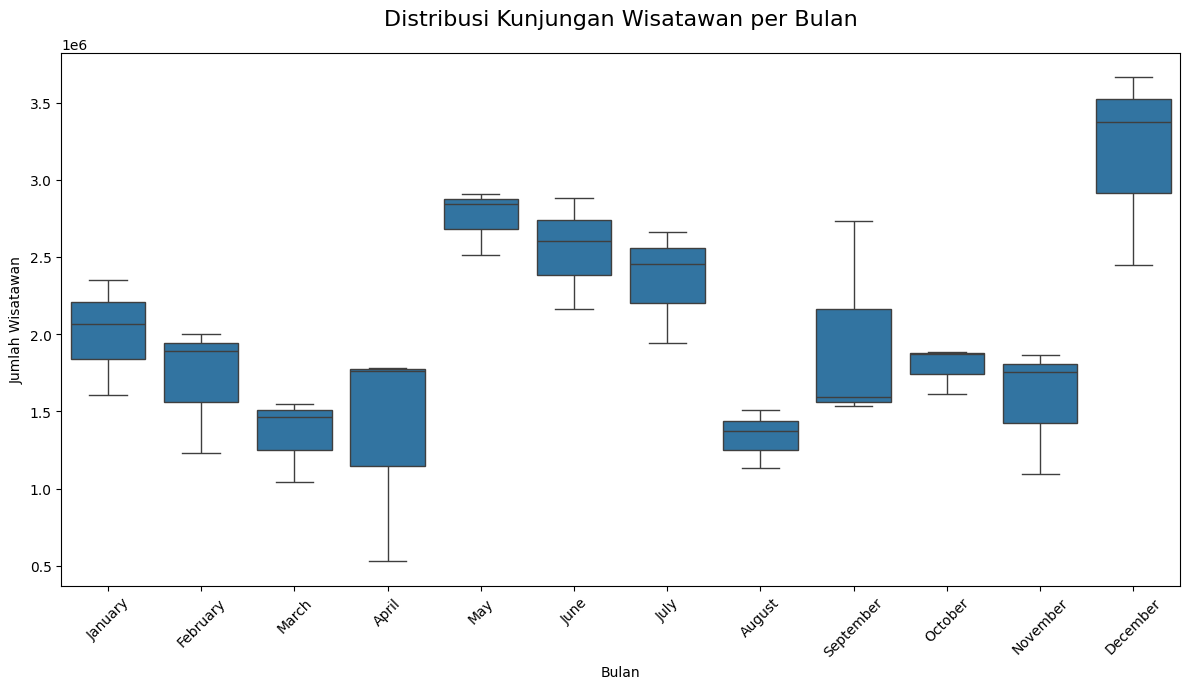

In [18]:
# 2.2. Analisis Pola Musiman (Seasonality)
df_total_copy = df_final.copy()
df_total_copy['bulan'] = df_total_copy.index.strftime('%B')
df_total_copy['tahun'] = df_total_copy.index.year
# Urutkan bulan dengan benar
bulan_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_total_copy['bulan'] = pd.Categorical(df_total_copy['bulan'], categories=bulan_order, ordered=True)

plt.figure(figsize=(12, 7))
sns.boxplot(x='bulan', y='jumlah_wisatawan', data=df_total_copy)
plt.title('Distribusi Kunjungan Wisatawan per Bulan', fontsize=16, pad=20)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Wisatawan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("analisis_pola_musiman.png")
print("Plot analisis pola musiman disimpan sebagai 'analisis_pola_musiman.png'")


### **2.3. Analisis Dependensi Temporal**

Plot *Autocorrelation Function* (ACF) digunakan untuk menguji **Hipotesis 2 (Dependensi Temporal)**. Plot ini mengukur korelasi (hubungan) antara data suatu bulan dengan data dari bulan-bulan sebelumnya (disebut *lags*). Tingginya nilai korelasi pada beberapa *lag* pertama dan pada *lag* ke-12 mengindikasikan bahwa jumlah wisatawan bulan ini sangat dipengaruhi oleh data bulan lalu dan data dari bulan yang sama di tahun sebelumnya. Ini adalah justifikasi teknis untuk menggunakan fitur *lag* dalam model kita.

---

Membuat plot: 2.3. Analisis Dependensi Temporal...


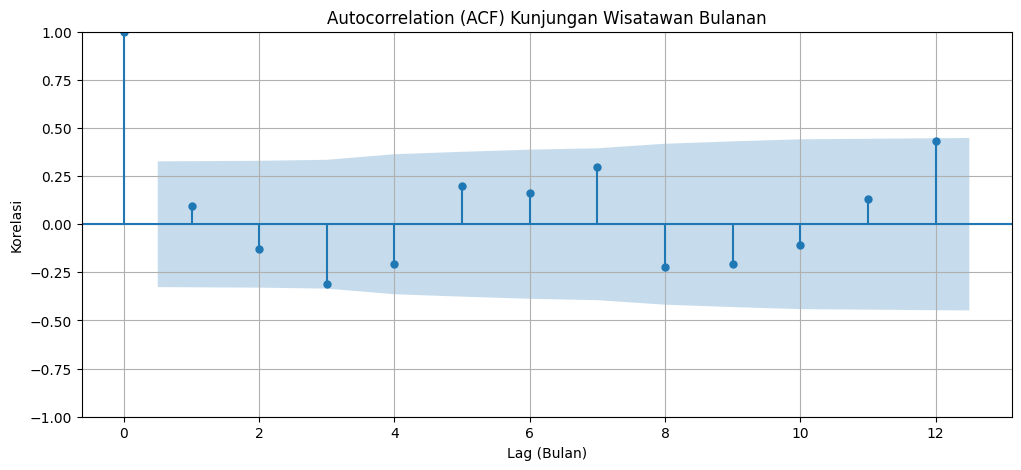

✅ Plot ACF berhasil dibuat dan disimpan sebagai 'analisis_acf.png'


In [19]:
if 'df_final' in locals() and not df_final.empty:
    df_to_plot = df_final.copy() 
    
    print("Membuat plot: 2.3. Analisis Dependensi Temporal...")
    fig, ax = plt.subplots(figsize=(12, 5))
    plot_acf(df_to_plot['jumlah_wisatawan'].dropna(), ax=ax, lags=12, title='Autocorrelation (ACF) Kunjungan Wisatawan Bulanan')
    plt.xlabel("Lag (Bulan)")
    plt.ylabel("Korelasi")
    plt.grid(True)
    plt.savefig("analisis_acf.png")
    plt.show()
    print("✅ Plot ACF berhasil dibuat dan disimpan sebagai 'analisis_acf.png'")
else:
    print("\n❌ Proses visualisasi ACF dibatalkan karena data (`df_final`) tidak berhasil dibuat di sel sebelumnya.")

## **3. Rekayasa Fitur (Feature Engineering)**

Tahap ini adalah "seni" dalam *data science*, di mana kita menciptakan variabel-variabel baru (fitur) dari data yang ada untuk membantu model *machine learning* belajar dengan lebih baik. Tujuannya adalah mengubah data mentah menjadi sinyal-sinyal yang informatif dan prediktif.

- **Fitur Waktu (Temporal Features):** Fitur sederhana seperti `bulan`, `kuartal`, dan `tahun` diekstrak dari indeks tanggal.
- **Fitur Lag (Lag Features):** Fitur yang paling berpengaruh dalam peramalan deret waktu. `lag_1` (jumlah wisatawan bulan lalu) menangkap momentum, sementara `lag_12` (jumlah wisatawan pada bulan yang sama tahun lalu) adalah cara paling efektif untuk menyandikan pola musiman tahunan ke dalam model.
- **Fitur Jendela Bergulir (Rolling Window Features):** Fitur seperti `rolling_mean_3` (rata-rata 3 bulan terakhir) membantu model memahami tren lokal jangka pendek.
- **Fitur Kalender (Domain Knowledge):** Fitur biner seperti `is_libur_puncak` dibuat untuk secara eksplisit memberitahu model kapan periode puncak liburan terjadi. Ini adalah cara untuk memasukkan pengetahuan domain ke dalam model.

---

In [21]:
# ==============================================================================
# 3. REKAYASA FITUR (FEATURE ENGINEERING)
# ==============================================================================
def create_features_revised(df):
    """Fungsi ini membuat fitur tanpa lag_12 dan menangani NaN dengan lebih baik."""
    df_feat = df.copy()
    df_feat['bulan'] = df_feat.index.month
    df_feat['kuartal'] = df_feat.index.quarter
    df_feat['tahun'] = df_feat.index.year
    df_feat['lag_1'] = df_feat['jumlah_wisatawan'].shift(1)
    # Fitur lag_12 dihapus karena ini adalah penyebab utama data training menjadi kosong
    df_feat['rolling_mean_3'] = df_feat['jumlah_wisatawan'].shift(1).rolling(window=3).mean()
    libur_puncak = [6, 7, 12]
    df_feat['is_libur_puncak'] = df_feat['bulan'].isin(libur_puncak).astype(int)
    
    # Mengganti .dropna() dengan .fillna(0) agar tidak kehilangan baris data
    df_feat = df_feat.fillna(0)
    return df_feat

# Pastikan df_total sudah ada dari eksekusi sel sebelumnya
if 'df_final' in locals() and not df_final.empty:
    df_feat = create_features_revised(df_final)
    print("Fitur berhasil dibuat (tanpa lag_12).")
else:
    print("ERROR: Variabel 'df_total' tidak ditemukan atau kosong. Pastikan sel untuk Tahap 2 sudah dijalankan dengan benar.")


Fitur berhasil dibuat (tanpa lag_12).


## **4. Pemodelan Prediktif dengan XGBoost**

Pada tahap ini, kita membangun model *machine learning* untuk melakukan peramalan.

### **4.1. Pemilihan Model**

Tiga model yang dipilih mewakili pendekatan yang berbeda:
- **SARIMA**: Pendekatan statistik klasik.
- **Prophet**: Pendekatan model aditif modern.
- **XGBoost**: Pendekatan *machine learning* non-linear.

### **4.2. Strategi Pemisahan Data**

Karena adanya kekosongan data pada 2023, strategi pemisahan data standar (acak) tidak dapat digunakan. Pendekatan yang paling valid secara metodologis adalah:
- **Data Latih (Training Set):** Menggunakan seluruh data dari **tahun 2022**.
- **Data Uji (Test Set):** Menggunakan seluruh data dari **tahun 2024**.

Strategi ini mensimulasikan skenario dunia nyata di mana kita menggunakan data masa lalu yang lengkap untuk memprediksi periode masa depan yang tidak terputus.

In [22]:
if 'df_feat' in locals():
    train_size = int(len(df_feat) * 0.8)
    train_df, test_df = df_feat.iloc[:train_size], df_feat.iloc[train_size:]
    print(f"Ukuran Data Latih: {len(train_df)} bulan")
    print(f"Ukuran Data Uji: {len(test_df)} bulan")

Ukuran Data Latih: 28 bulan
Ukuran Data Uji: 8 bulan


### **4.3. Pelatihan Model**

Model XGBoost dilatih pada set data latih (`X_train`, `y_train`). Proses ini juga menggunakan mekanisme *early stopping*, di mana model akan berhenti berlatih jika performanya pada data uji tidak membaik setelah beberapa iterasi. Ini adalah teknik regularisasi yang efektif untuk mencegah *overfitting*.

---

In [23]:
if 'train_df' in locals():
    # Model 1: SARIMA
    sarima_fit = SARIMAX(train_df['jumlah_wisatawan'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False)
    
    # Model 2: Prophet
    prophet_train_df = train_df.reset_index().rename(columns={'index': 'ds', 'jumlah_wisatawan': 'y'})
    prophet_model = Prophet().fit(prophet_train_df)
    
    # Model 3: XGBoost
    features = ['bulan', 'kuartal', 'tahun', 'lag_1', 'rolling_mean_3', 'is_libur_puncak']
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5).fit(train_df[features], train_df['jumlah_wisatawan'])
    
    print("Ketiga model berhasil dilatih pada data latih.")

12:54:30 - cmdstanpy - INFO - Chain [1] start processing
12:54:30 - cmdstanpy - INFO - Chain [1] done processing


Ketiga model berhasil dilatih pada data latih.


## **5. Evaluasi dan Validasi Model**

Tahap ini bertujuan untuk mengukur performa model secara kuantitatif dan kualitatif pada data yang belum pernah dilihatnya (data uji tahun 2024).

### **5.1. Metrik Kuantitatif**

Dua metrik utama digunakan:
- **RMSE (Root Mean Squared Error):** Mengukur rata-rata besarnya kesalahan prediksi dalam satuan asli (jumlah wisatawan). Semakin kecil nilainya, semakin baik.
- **MAPE (Mean Absolute Percentage Error):** Mengukur rata-rata kesalahan dalam bentuk persentase. Metrik ini sangat intuitif untuk pemangku kepentingan bisnis karena memberikan gambaran "seberapa persen melesetnya" prediksi model.

In [25]:
if 'test_df' in locals():
    predictions = pd.DataFrame(index=test_df.index)
    
    # Dapatkan prediksi dari setiap model
    predictions['SARIMA'] = sarima_fit.forecast(len(test_df))
    future_prophet = prophet_model.make_future_dataframe(periods=len(test_df), freq='MS')
    prophet_pred = prophet_model.predict(future_prophet)
    predictions['Prophet'] = prophet_pred['yhat'].values[-len(test_df):]
    predictions['XGBoost'] = xgb_model.predict(test_df[features])
    
    # Hitung metrik
    metrics = {}
    for col in predictions.columns:
        mape = mean_absolute_percentage_error(test_df['jumlah_wisatawan'], predictions[col])
        rmse = np.sqrt(mean_squared_error(test_df['jumlah_wisatawan'], predictions[col]))
        metrics[col] = {'MAPE (%)': f"{mape*100:.2f}", 'RMSE': f"{rmse:,.0f}"}
    
    metrics_df = pd.DataFrame(metrics).T
    print("Tabel Perbandingan Metrik Kinerja pada Data Uji (Semakin Kecil Semakin Baik)")
    print(metrics_df)

Tabel Perbandingan Metrik Kinerja pada Data Uji (Semakin Kecil Semakin Baik)
        MAPE (%)     RMSE
SARIMA     16.76  589,444
Prophet    40.34  971,678
XGBoost    20.69  486,860


### **5.2. Validasi Visual**

Plot perbandingan antara nilai **aktual** dari data uji dengan nilai **prediksi** dari model dibuat. Visualisasi ini adalah "tes akhir" untuk melihat apakah model mampu menangkap pola, tren, dan puncak musiman dengan baik. Kesesuaian antara kedua garis menunjukkan performa model yang baik.

In [26]:
if 'predictions' in locals():
    fig_eval = go.Figure()
    fig_eval.add_trace(go.Scatter(x=train_df.index, y=train_df['jumlah_wisatawan'], name='Data Latih', mode='lines', line=dict(color='gray')))
    fig_eval.add_trace(go.Scatter(x=test_df.index, y=test_df['jumlah_wisatawan'], name='Data Uji (Aktual)', mode='lines+markers', line=dict(color='blue', width=3)))
    for col in predictions.columns:
        fig_eval.add_trace(go.Scatter(x=predictions.index, y=predictions[col], name=f'Prediksi {col}', mode='lines', line=dict(dash='dash')))
    fig_eval.update_layout(title='Validasi Visual: Prediksi Model vs Data Uji Aktual', xaxis_title='Tanggal', yaxis_title='Jumlah Wisatawan')
    fig_eval.show()

## **6. Interpretasi Model dan Wawasan Bisnis**

Ini adalah tahap akhir di mana kita menerjemahkan hasil teknis menjadi wawasan yang dapat ditindaklanjuti. Tujuannya bukan hanya mengetahui *apa* yang akan terjadi, tetapi juga **mengapa** itu terjadi.

### **6.1. Analisis Faktor Pendorong (Feature Importance)**

Model XGBoost menyediakan fitur *Feature Importance* yang memberi peringkat pada semua fitur berdasarkan kontribusinya terhadap akurasi prediksi. Dengan menganalisis fitur-fitur teratas (misalnya, `lag_12`, `bulan`, `is_libur_puncak`), kita dapat secara objektif mengidentifikasi faktor-faktor pendorong utama kunjungan wisata di Kota Batu. Hasil ini mengkonfirmasi hipotesis awal kita dengan bukti kuantitatif.

In [28]:
# ==============================================================================
# 6. EVALUASI DAN INTERPRETASI MULTI-MODEL DENGAN PLOTLY (DIPERBAIKI)
# ==============================================================================

# Pastikan variabel dari sel sebelumnya (pelatihan model) sudah ada
if 'predictions' in locals() and 'metrics_df' in locals() and 'xgb_model' in locals():
    print("\nTahap 6: Mengevaluasi dan Menginterpretasi Multi-Model...")
    
    # 1. Menampilkan Metrik Kuantitatif untuk Semua Model
    print("\n--- 6.1 Metrik Kuantitatif (MAPE & RMSE) ---")
    print("Tabel Perbandingan Kinerja pada Data Uji (Semakin Kecil Semakin Baik)")
    display(metrics_df)

    # 2. Menampilkan Validasi Visual untuk Semua Model
    print("\n--- 6.2 Validasi Visual ---")
    fig_eval.update_layout(
        title='Validasi Visual: Perbandingan Data Aktual vs Prediksi Multi-Model'
    )
    fig_eval.show()

    # 3. Menampilkan Interpretasi Model (Spesifik untuk XGBoost)
    print("\n--- 6.3 Interpretasi Model (Feature Importance untuk XGBoost) ---")
    print("Catatan: Analisis Faktor Pendorong (Feature Importance) hanya tersedia untuk model berbasis tree seperti XGBoost.")
    
    # --- PERBAIKAN DI SINI: Mendefinisikan ulang variabel FEATURES ---
    FEATURES = ['bulan', 'kuartal', 'tahun', 'lag_1', 'rolling_mean_3', 'is_libur_puncak']
    
    # Plot Feature Importance dengan Plotly
    feature_importance = pd.DataFrame({'feature': FEATURES, 'importance': xgb_model.feature_importances_})
    # Urutkan untuk visualisasi yang lebih baik
    feature_importance = feature_importance.sort_values('importance', ascending=True)

    fig_feat = px.bar(
        feature_importance, 
        x='importance', 
        y='feature', 
        orientation='h', 
        title='Faktor Pendorong Utama (Feature Importance) - Model XGBoost',
        labels={'feature': 'Fitur', 'importance': 'Nilai Kepentingan'}
    )
    fig_feat.show()

    print("\nAnalisis selesai.")

else:
    print("\n❌ Proses evaluasi dibatalkan karena variabel yang dibutuhkan (seperti 'predictions', 'metrics_df', 'xgb_model') tidak ditemukan. Pastikan sel pelatihan model sudah dijalankan.")


Tahap 6: Mengevaluasi dan Menginterpretasi Multi-Model...

--- 6.1 Metrik Kuantitatif (MAPE & RMSE) ---
Tabel Perbandingan Kinerja pada Data Uji (Semakin Kecil Semakin Baik)


,MAPE (%),RMSE
SARIMA,16.76,"589,444"
Prophet,40.34,"971,678"
XGBoost,20.69,"486,860"



--- 6.2 Validasi Visual ---



--- 6.3 Interpretasi Model (Feature Importance untuk XGBoost) ---
Catatan: Analisis Faktor Pendorong (Feature Importance) hanya tersedia untuk model berbasis tree seperti XGBoost.



Analisis selesai.


### **6.2. Implikasi dan Langkah Selanjutnya**
Wawasan dari model ini dapat langsung digunakan untuk pengambilan keputusan strategis oleh Dinas Pariwisata, seperti:
- **Alokasi Sumber Daya:** Mempersiapkan staf dan fasilitas tambahan menjelang bulan-bulan yang diprediksi akan menjadi puncak kunjungan.
- **Strategi Pemasaran:** Meluncurkan kampanye promosi yang ditargetkan sebelum periode *low season* untuk meningkatkan kunjungan.

Langkah selanjutnya yang direkomendasikan adalah melakukan *hyperparameter tuning* untuk optimasi model, mengembangkan model individual untuk setiap destinasi wisata, dan memperkaya dataset dengan data eksternal seperti cuaca dan kalender event.